### VAR : Vector Auto Regression models!

##### However, there are some cases where variables affect each other i.e. exogeneous variables are also affected by some other variable!
##### In such cases , we can attempt to use Vector AutoRegression model.

##### General steps involved in building VAR model:

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline

from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse

import warnings
warnings.filterwarnings("ignore")

df = pd.read_csv("C:\\Users\\shaleens\\Desktop\\Projects\\TimeSeriesUdacity\\TS Udemy Vids\\Time Series 2\\VAR model dataset\\M2.csv", index_col=0, parse_dates=True)
df.index.freq = 'MS'

sp = pd.read_csv("C:\\Users\\shaleens\\Desktop\\Projects\\TimeSeriesUdacity\\TS Udemy Vids\\Time Series 2\\VAR model dataset\\PCE.csv", index_col=0, parse_dates=True)
sp.index.freq = 'MS'

In [2]:
df.rename(columns={'M2NS':'Money'}, inplace=True)

In [3]:
sp.rename(columns={'PCE':'Spend'}, inplace=True)

In [4]:
# Lets go ahead and combines the 2 dataframes:

df = pd.merge(df, sp, how='inner', on='DATE')

In [5]:
df.head()

,Money,Spend
DATE,,
1995-01-01,3495.3,4851.2
1995-02-01,3474.9,4850.8
1995-03-01,3491.7,4885.4
1995-04-01,3522.4,4890.2
1995-05-01,3506.7,4933.1


In [6]:
df.shape

(300, 2)

In [7]:
df.dropna().shape 
# This confirms that there is no null value to be treated

(300, 2)

In [8]:
df = df.iloc[:252]

In [9]:
df.tail()

,Money,Spend
DATE,,
2015-08-01,12058.7,12387.0
2015-09-01,12126.3,12384.5
2015-10-01,12159.8,12387.3
2015-11-01,12286.2,12422.8
2015-12-01,12416.1,12453.8


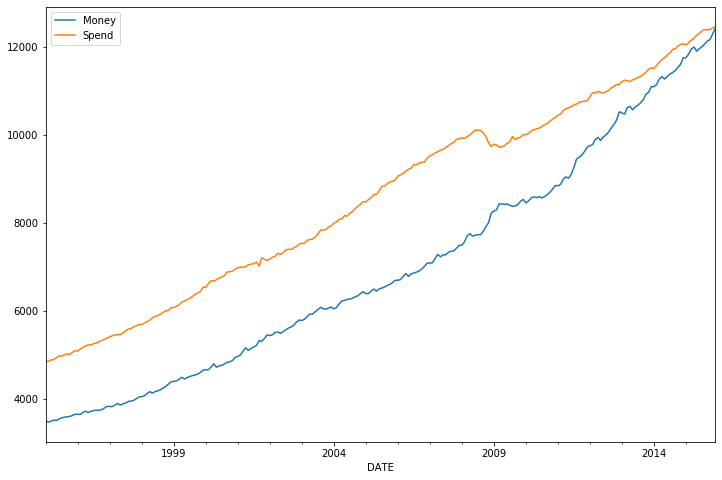

In [10]:
df.plot(figsize=(12,8))

##### Test for Stationarity:

In [11]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series, title=''):
    '''
    Pass in a time series and an optional title, function returns an ADF report
    '''
    print(f'Augmented Dickey-fuller test: {title}')
    result = adfuller(series.dropna(), autolag='AIC') # dropna() handles differenced data
    
    labels = ['adf test stats','p-value', '# of lags', '# of observations']
    out = pd.Series(result[0:4], index=labels)
    
    for key,val in result[4].items():
        out[f'critical value ({key})'] = val
    
    print(out.to_string())
    
    if result[1] <= 0.05:
        print("Null Hypothesis rejected! Time series is stationary!")
    else:
        print("Failed to reject Null Hypothesis! Time Series is not stationary!")

In [12]:
adf_test(df['Money'])

Augmented Dickey-fuller test: 
adf test stats            2.360455
p-value                   0.998990
# of lags                16.000000
# of observations       235.000000
critical value (1%)      -3.458487
critical value (5%)      -2.873919
critical value (10%)     -2.573367
Failed to reject Null Hypothesis! Time Series is not stationary!


In [13]:
adf_test(df['Spend'])

Augmented Dickey-fuller test: 
adf test stats            0.124119
p-value                   0.967670
# of lags                 3.000000
# of observations       248.000000
critical value (1%)      -3.456996
critical value (5%)      -2.873266
critical value (10%)     -2.573019
Failed to reject Null Hypothesis! Time Series is not stationary!


##### Since we are working on VAR model and here we need to difference the series manually for making it stationary:

In [14]:
# Using inbuilt function of pandas dataframe for differencing the series:

df_transformed = df.diff()

In [15]:
df_transformed

,Money,Spend
DATE,,
1995-01-01,NaN,NaN
1995-02-01,-20.4,-0.4
1995-03-01,16.8,34.6
1995-04-01,30.7,4.8
1995-05-01,-15.7,42.9
...,...,...
2015-08-01,57.4,29.9
2015-09-01,67.6,-2.5
2015-10-01,33.5,2.8


In [16]:
### Lets check again if the data columns are stationary now:

adf_test(df_transformed['Money'])

Augmented Dickey-fuller test: 
adf test stats           -2.236522
p-value                   0.193258
# of lags                16.000000
# of observations       234.000000
critical value (1%)      -3.458608
critical value (5%)      -2.873972
critical value (10%)     -2.573396
Failed to reject Null Hypothesis! Time Series is not stationary!


In [17]:
adf_test(df_transformed['Spend'])

Augmented Dickey-fuller test: 
adf test stats         -7.289192e+00
p-value                 1.432037e-10
# of lags               2.000000e+00
# of observations       2.480000e+02
critical value (1%)    -3.456996e+00
critical value (5%)    -2.873266e+00
critical value (10%)   -2.573019e+00
Null Hypothesis rejected! Time series is stationary!


##### Money column is still non-stationary, whereas Spend column has become stationary! In such scenarios, we may need to apply differencing again to both the series coz we want the data in same number of rows in both the columns!

##### Because if you observe closely, each time you are differencing the dataframe you are losing one row of data!!


In [18]:
df_transformed = df_transformed.diff().dropna()

In [19]:
df_transformed.head()

,Money,Spend
DATE,,
1995-03-01,37.2,35.0
1995-04-01,13.9,-29.8
1995-05-01,-46.4,38.1
1995-06-01,54.5,1.5
1995-07-01,-14.6,-51.7


##### Notice that we have lost 2 rows of data i.e for Jan month and Feb month!

In [20]:
# Lets check for stataionarity again:

adf_test(df_transformed['Money'])

Augmented Dickey-fuller test: 
adf test stats         -5.855014e+00
p-value                 3.516701e-07
# of lags               1.500000e+01
# of observations       2.340000e+02
critical value (1%)    -3.458608e+00
critical value (5%)    -2.873972e+00
critical value (10%)   -2.573396e+00
Null Hypothesis rejected! Time series is stationary!


In [21]:
adf_test(df_transformed['Spend'])

Augmented Dickey-fuller test: 
adf test stats         -8.757023e+00
p-value                 2.737843e-14
# of lags               8.000000e+00
# of observations       2.410000e+02
critical value (1%)    -3.457779e+00
critical value (5%)    -2.873609e+00
critical value (10%)   -2.573202e+00
Null Hypothesis rejected! Time series is stationary!


##### Now the columns in dataframe are completely stationary!

In [22]:
df_transformed.shape

(250, 2)

##### Train-test split:

In [23]:
n_obs = 12

train = df_transformed[:-n_obs]
test = df_transformed[-n_obs:]

In [24]:
train.tail()

,Money,Spend
DATE,,
2014-08-01,-24.0,35.6
2014-09-01,16.9,-71.3
2014-10-01,19.8,59.9
2014-11-01,8.2,-37.8
2014-12-01,69.1,-17.0


In [25]:
test.head()

,Money,Spend
DATE,,
2015-01-01,-146.1,-39.9
2015-02-01,89.2,74.3
2015-03-01,21.6,7.4
2015-04-01,-62.0,-14.9
2015-05-01,-144.4,32.0


In [26]:
train.shape, test.shape

((238, 2), (12, 2))

##### Choosing the order 'p' (i.e. lag of auto-regressor) of VAR regression model using GRID Search:

In [27]:
model = VAR(train)

for p in range(10):
    results = model.fit(p)
    print(f'ORDER {p}')
    print(f'AIC:{results.aic}')
    print('\n')

ORDER 0
AIC:15.977435427374134


ORDER 1
AIC:15.477298931033475


ORDER 2
AIC:15.002894527933922


ORDER 3
AIC:14.856950442433046


ORDER 4
AIC:14.868520739397717


ORDER 5
AIC:14.855560641510024


ORDER 6
AIC:14.87381216589233


ORDER 7
AIC:14.69511933970116


ORDER 8
AIC:14.613709516286049


ORDER 9
AIC:14.645458094165294




##### Order 5 looks to have fairly small AIC

In [28]:
results = model.fit(5)

In [29]:
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 01, Mar, 2020
Time:                     19:07:49
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    15.1814
Nobs:                     233.000    HQIC:                   14.9870
Log likelihood:          -2369.90    FPE:                2.82976e+06
AIC:                      14.8556    Det(Omega_mle):     2.58037e+06
--------------------------------------------------------------------
Results for equation Money
              coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------
const            1.086035         2.938108            0.370           0.712
L1.Money        -0.749197         0.067960          -11.024           0.000
L1.Spend        -0.077878         0.082506           -0.944           0.345
L2.M

In [30]:
# p is the number of lagged values to be grabbed, k is number of variables and y needs an ndarray of 5*2 dimension
# So, we need to grab the last p values from the train, just before the test set starts!
# We need to pass numpy array of it!.values

lagged_vals = train[-5:].values
lagged_vals.shape

(5, 2)

In [31]:
df_forecast = results.forecast(y=lagged_vals, steps = 12) # steps is number of periods to predict.

In [32]:
df_forecast

array([[-71.29482311,  28.40627812],
       [  3.5010023 ,  -3.8373162 ],
       [ 22.23050851,  -9.26069847],
       [ -4.16519208,  12.9204468 ],
       [-11.21264583,  -9.51456587],
       [ 10.72150132,  -0.27487544],
       [ -1.01418791,   4.8455572 ],
       [ -1.98197513,  -1.35031698],
       [  0.25918625,  -1.81690257],
       [  2.23350228,   2.40454145],
       [ -0.95482263,  -1.27675505],
       [  0.18368543,   0.07152578]])

In [33]:
idx = pd.date_range('2015-01-01','2015-12-01',freq='MS')

In [34]:
df_forecast = pd.DataFrame(data=df_forecast, index=idx, columns=['Money_2d','Spend_2d'])

In [35]:
df_forecast

,Money_2d,Spend_2d
2015-01-01,-71.294823,28.406278
2015-02-01,3.501002,-3.837316
2015-03-01,22.230509,-9.260698
2015-04-01,-4.165192,12.920447
2015-05-01,-11.212646,-9.514566
2015-06-01,10.721501,-0.274875
2015-07-01,-1.014188,4.845557
2015-08-01,-1.981975,-1.350317
2015-09-01,0.259186,-1.816903
2015-10-01,2.233502,2.404541


##### Inverting the Transformation:

In [36]:
df.shape

(252, 2)

In [37]:
df['Money'].iloc[-n_obs-1]

11747.9

In [38]:
df['Money'].iloc[-n_obs-2]

11602.8

In [39]:
df_forecast['Money_2d'].cumsum()

2015-01-01   -71.294823
2015-02-01   -67.793821
2015-03-01   -45.563312
2015-04-01   -49.728504
2015-05-01   -60.941150
2015-06-01   -50.219649
2015-07-01   -51.233837
2015-08-01   -53.215812
2015-09-01   -52.956626
2015-10-01   -50.723123
2015-11-01   -51.677946
2015-12-01   -51.494261
Freq: MS, Name: Money_2d, dtype: float64

In [40]:
df['Money'].iloc[-13]

11747.9

In [41]:
df_forecast['Money_1d'] = (df['Money'].iloc[-n_obs-1] - df['Money'].iloc[-n_obs-2]) + df_forecast['Money_2d'].cumsum()

df_forecast['MoneyForecast'] = df['Money'].iloc[-n_obs-1] + df_forecast['Money_1d'].cumsum()

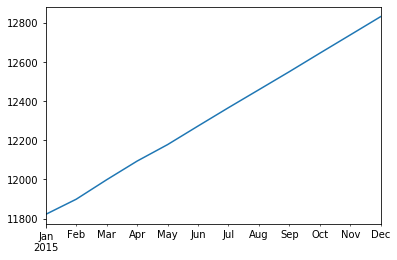

In [42]:
df_forecast['MoneyForecast'].plot()

In [43]:
df_forecast['Spend_1d'] = (df['Spend'].iloc[-n_obs-1] - df['Spend'].iloc[-n_obs-2]) + df_forecast['Spend_2d'].cumsum()

df_forecast['SpendForecast'] = df['Spend'].iloc[-n_obs-1] + df_forecast['Spend_1d'].cumsum()

In [44]:
df_forecast['SpendForecast']

2015-01-01    12108.206278
2015-02-01    12147.575240
2015-03-01    12177.683503
2015-04-01    12220.712214
2015-05-01    12254.226358
2015-06-01    12287.465627
2015-07-01    12325.550453
2015-08-01    12362.284962
2015-09-01    12397.202569
2015-10-01    12434.524717
2015-11-01    12470.570110
2015-12-01    12506.687029
Freq: MS, Name: SpendForecast, dtype: float64

In [50]:
df_forecast.head()

,Money_2d,Spend_2d,Money_1d,MoneyForecast,Spend_1d,SpendForecast
2015-01-01,-71.294823,28.406278,73.805177,11821.705177,43.206278,12108.206278
2015-02-01,3.501002,-3.837316,77.306179,11899.011356,39.368962,12147.575240
2015-03-01,22.230509,-9.260698,99.536688,11998.548044,30.108263,12177.683503
2015-04-01,-4.165192,12.920447,95.371496,12093.919539,43.028710,12220.712214
2015-05-01,-11.212646,-9.514566,84.158850,12178.078389,33.514144,12254.226358


In [53]:
test_range = df[-n_obs:]

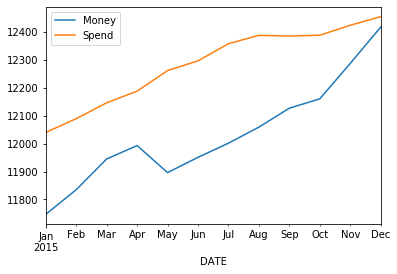

In [54]:
test_range.plot()

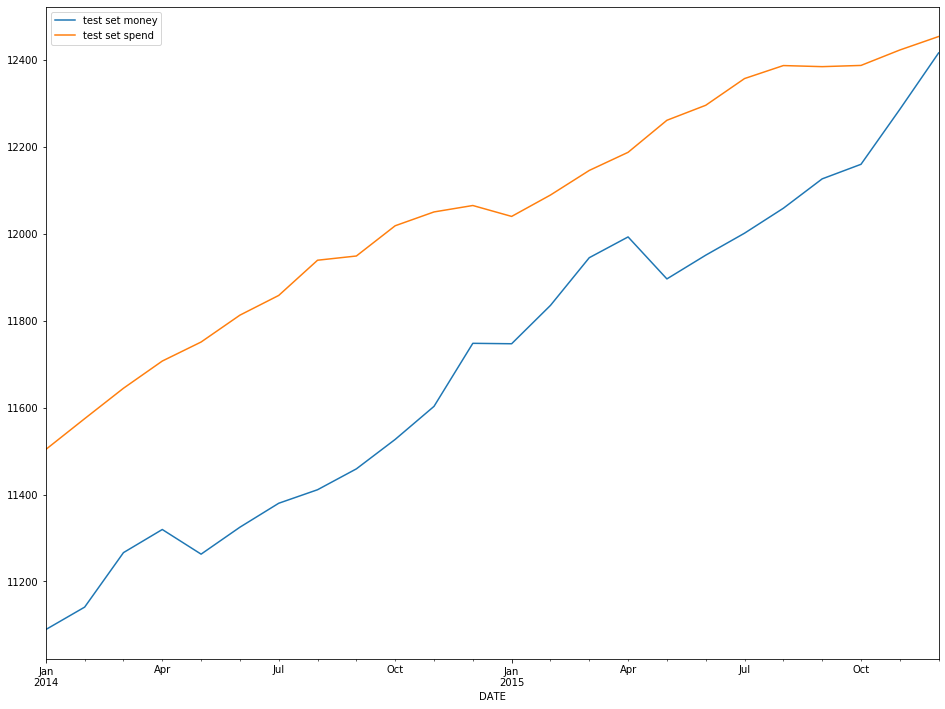

In [55]:
df['Money']['2014-01-01':].rename('test set money').plot(figsize=(16,12), legend=True)
df['Spend']['2014-01-01':].rename('test set spend').plot(legend=True)

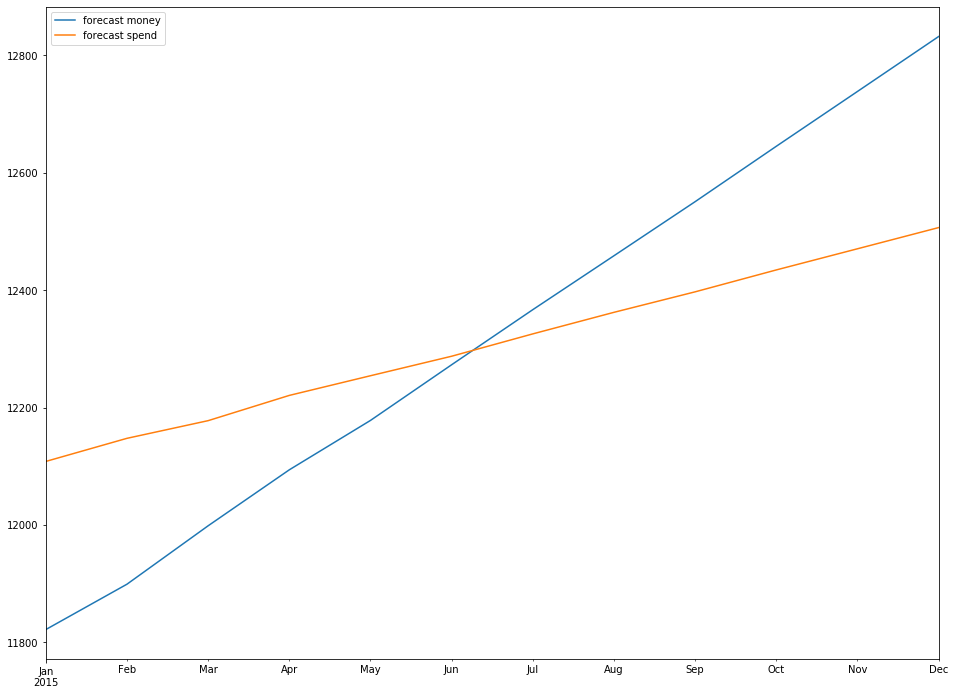

In [57]:
df_forecast['MoneyForecast'].rename('forecast money').plot(legend=True, figsize=(16,12))
df_forecast['SpendForecast'].rename('forecast spend').plot(legend=True)

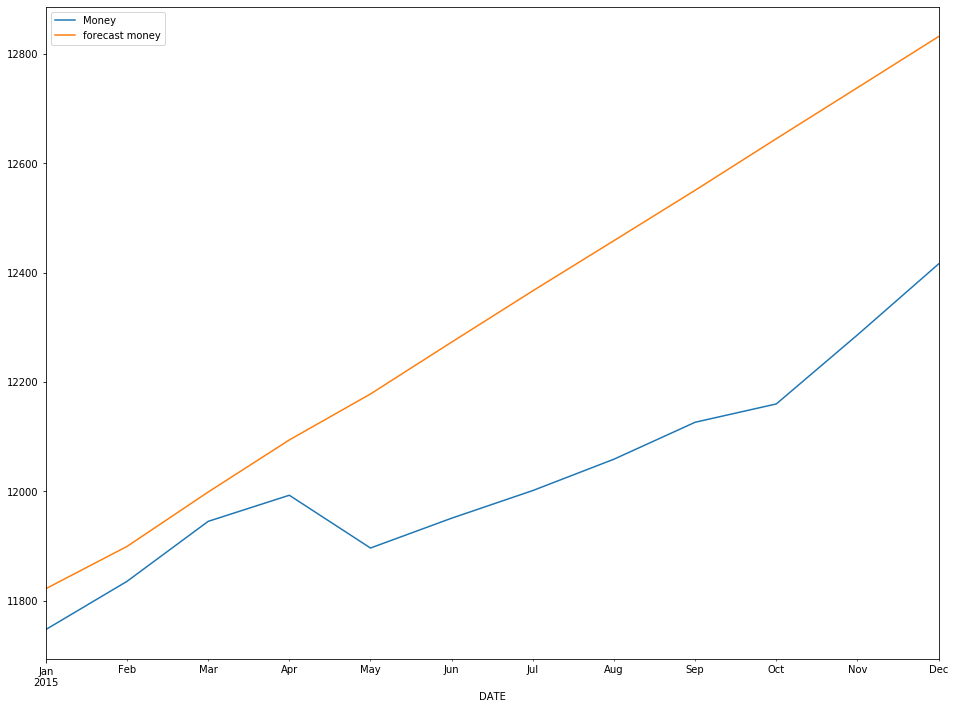

In [60]:
test_range['Money'].plot(figsize=(16,12), legend=True)
df_forecast['MoneyForecast'].rename('forecast money').plot(legend=True, figsize=(16,12))

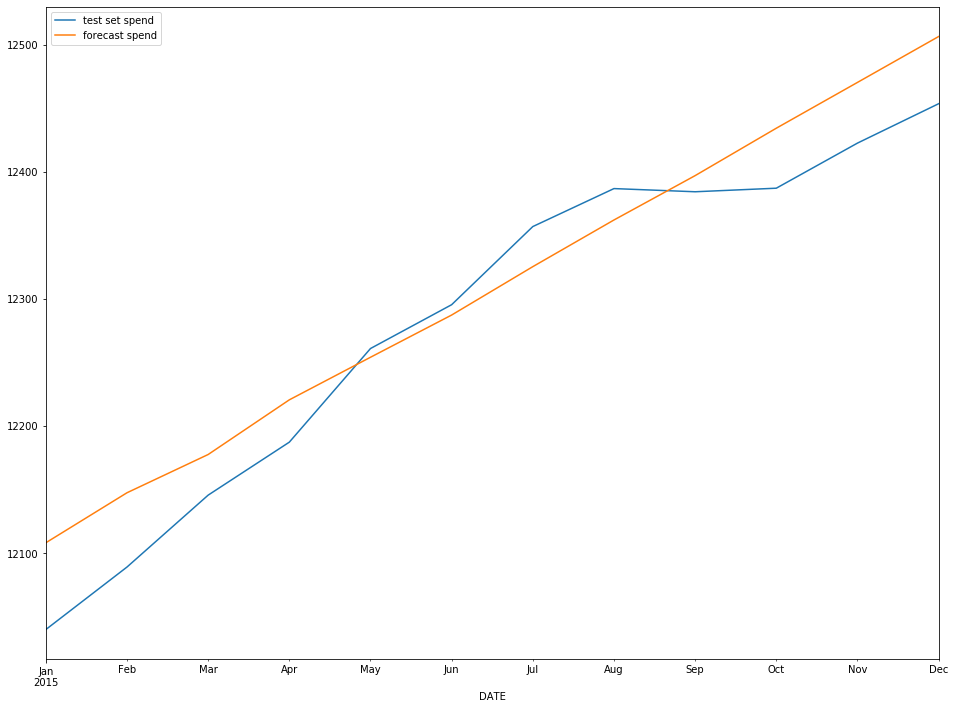

In [63]:
test_range['Spend'].rename('test set spend').plot(legend=True, figsize=(16,12))
df_forecast['SpendForecast'].rename('forecast spend').plot(legend=True)

In [64]:
rmse(test_range['Money'], df_forecast['MoneyForecast'])

328.3250029111213

In [65]:
test_range['Money'].mean()

12034.566666666668

In [66]:
rmse(test_range['Spend'], df_forecast['SpendForecast'])

40.216001906433675

In [67]:
test_range['Spend'].mean()

12284.275